<a href="https://colab.research.google.com/github/jasondupree/jasondupree.github.io/blob/main/power_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook Preparation**

## Mount Drive and Update Display

In [6]:
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)  # Ensures all columns are displayed
pd.set_option('display.width', None)        # Utilizes the maximum width of your display

from IPython.display import display, HTML

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import yeojohnson, boxcox
from scipy.optimize import minimize_scalar

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

# Suppress ConvergenceWarning for this context
warnings.simplefilter('ignore', ConvergenceWarning)

## Import Data

In [8]:
# Adjust the path to the location of your CSV file
file_path = '/content/drive/My Drive/Business Courses/Analytics in Finance/Power Transformations/Exercise 1/bonddata.txt'

data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
data.head(3)

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,10,1,126.268,7.616851,5.95,25.940349,0,12.540,150000.0,3,126.017363,343747,125.101,400000.0,3,124.717608,345050,124.757,1000000.0,3,124.721953,684386,126.061,220000.0,3,126.180334,1295498,128.8910,29000.0,4,126.636079,1308464,124.918,10000.0,2,125.736081,2152948,126.362,5000001.0,2,127.025765,2157390,126.8800,4200000.0,3,126.761433,2407701,126.673,85000.0,4,126.323528,2862729,128.596,120000.0,2,127.561201,3621492,129.089,200000.0,2,129.435587
1,38,2,101.009,0.018373,3.55,0.326392,0,9.327,450000.0,3,101.068546,1,101.009,450000.0,2,101.068546,3694,100.850,25000.0,2,101.066038,8018,100.995,3000000.0,2,101.066114,9168,101.0184,3000000.0,3,101.067077,18344,100.963,50000.0,2,101.063294,348445,100.966,15000.0,2,101.062981,448618,100.9777,25000.0,2,101.077405,523506,101.033,25000.0,2,101.101928,532644,101.086,500000.0,2,101.103180,538510,101.070,25000.0,2,101.102243
2,336,3,108.144,3.537380,4.20,2.340601,0,0.102,160000.0,4,107.927659,74139,107.990,6000.0,2,107.922875,74659,107.990,6000.0,4,107.920620,83993,108.414,75000.0,3,107.963427,84037,108.1400,75000.0,4,107.938385,84729,107.965,2000.0,4,107.934646,84729,107.965,2000.0,2,107.934646,85567,108.4290,5000.0,3,107.932542,92007,108.246,38000.0,2,107.900618,96293,107.917,400000.0,2,107.874965,96293,107.917,400000.0,4,107.874965


# EX1

## Question One
This exercise is based on the "Benchmark Bond Trade Price Challenge" which
was conducted on the web site Kaggle.com.
You can see the full details of this challenge at
[http://www.kaggle.com/c/benchmark-bond-trade-price-challenge](http://www.kaggle.com/c/benchmark-bond-trade-price-challenge),
but you may have to register (it is free).
This is reproduced from the "Background" section:

<blockquote>
As far as price transparency is concerned, there has historically been a huge gap between the amount of reference information available to those trading equities versus those trading corporate bonds.  Stock exchanges report trades, bids and offers at all times.  Free access is available online with a 15 minute delay while traders who demand more information can pay for ultra efficient real time data and information about size of current bids and offers. By contrast, bond trades are required to be reported within 15 minutes and only those who pay for the TRACE feed can access this information.  No quotes are publicly available and the best way to get a quote is to solicit multiple brokers and wait for a reply.  Alternatively there are data companies that provide end of day prices, published after the market has closed and with no guarantee that the specific information sought will be included.  Accurate bond pricing is also hindered by lack of liquidity.  Only a fraction of TRACE eligible bonds trade on a given day, so the most recent trade price is often multiple days old.  Pricing bonds based on other more liquid bonds that have similar features is common, but again limited by the presence of such bonds.

Benchmark Solutions is the first provider of realtime corporate bond prices. Every 10 seconds we provide accurate prices that incorporate interest rate data, trades or quotes of the bond in question, trades or quotes of other bonds or CDS of the issuer of the bond in question as well as other input sources.  Pricing bonds accurately requires an exacting knowledge of payment schedules, trading calenders and reference data for each bond.  This, as well as synthesizing all of the bonds and CDS quotes and trades of a given issuer into implied hazard and funding curves, is something that we feel is beyond the scope of this challenge.  Rather, we provide you with a reference price which is an intermediate result of our calculations and is labeled 'curve\_based\_price'  in the dataset. Thus the competition focuses on trading dynamics and microstructure of individual bonds, rather than all bonds from a given issuer.
</blockquote>

We created a reduced data set in order to make this challenge
something we could manage during this exercise. This data file (bonddata.txt) is available on CANVAS.

We will fit regression models which attempt to model `trade_price`

## Setup

This initial portion of code reads in the data set.

The size of the data set.

In [9]:
data.shape

(1620, 61)

These next commands remove some variables which are not useful predictors, and define some variables to be categorical.

In [10]:
data = data.drop(['id', 'bond_id'], axis=1)

In [31]:
data['is_callable'] = data['is_callable'].astype('category').cat.as_unordered()
data['trade_type'] = data['trade_type'].astype('category').cat.as_unordered()
data['trade_type_last1'] = data['trade_type_last1'].astype('category').cat.as_unordered()
data['trade_type_last2'] = data['trade_type_last2'].astype('category').cat.as_unordered()
data['trade_type_last3'] = data['trade_type_last3'].astype('category').cat.as_unordered()
data['trade_type_last4'] = data['trade_type_last4'].astype('category').cat.as_unordered()
data['trade_type_last5'] = data['trade_type_last5'].astype('category').cat.as_unordered()
data['trade_type_last6'] = data['trade_type_last6'].astype('category').cat.as_unordered()
data['trade_type_last7'] = data['trade_type_last7'].astype('category').cat.as_unordered()
data['trade_type_last8'] = data['trade_type_last8'].astype('category').cat.as_unordered()
data['trade_type_last9'] = data['trade_type_last9'].astype('category').cat.as_unordered()
data['trade_type_last10'] = data['trade_type_last10'].astype('category').cat.as_unordered()

## Transforming Predictors

Some of the non-categorical predictors have distributions which are highly skewed. For example, take a look at the  histogram below.

<Axes: >

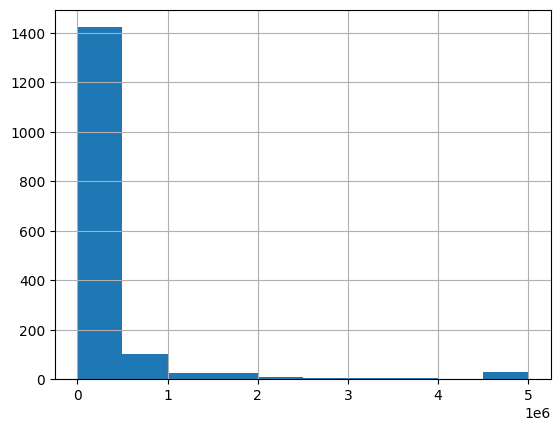

In [11]:
data['trade_size_last1'].hist()

For predictors with such a distribution, it can be a very good idea to transform them prior to fitting the model. For strictly positive variables, a log transform is common, while for nonnegative variables a square root transform has a similar effect. For this reason, the following transformations are applied.

In [12]:
data['time_to_maturity_lt'] = np.log(data['time_to_maturity'])
data['trade_size_lt'] = np.log(data['trade_size'])

data['trade_size_last1_lt'] = np.log(data['trade_size_last1'])
data['trade_size_last2_lt'] = np.log(data['trade_size_last2'])
data['trade_size_last3_lt'] = np.log(data['trade_size_last3'])
data['trade_size_last4_lt'] = np.log(data['trade_size_last4'])
data['trade_size_last5_lt'] = np.log(data['trade_size_last5'])
data['trade_size_last6_lt'] = np.log(data['trade_size_last6'])
data['trade_size_last7_lt'] = np.log(data['trade_size_last7'])
data['trade_size_last8_lt'] = np.log(data['trade_size_last8'])
data['trade_size_last9_lt'] = np.log(data['trade_size_last9'])
data['trade_size_last10_lt'] = np.log(data['trade_size_last10'])

data['received_time_diff_last1_st'] = np.sqrt(data['received_time_diff_last1'])
data['received_time_diff_last2_st'] = np.sqrt(data['received_time_diff_last2'])
data['received_time_diff_last3_st'] = np.sqrt(data['received_time_diff_last3'])
data['received_time_diff_last4_st'] = np.sqrt(data['received_time_diff_last4'])
data['received_time_diff_last5_st'] = np.sqrt(data['received_time_diff_last5'])
data['received_time_diff_last6_st'] = np.sqrt(data['received_time_diff_last6'])
data['received_time_diff_last7_st'] = np.sqrt(data['received_time_diff_last7'])
data['received_time_diff_last8_st'] = np.sqrt(data['received_time_diff_last8'])
data['received_time_diff_last9_st'] = np.sqrt(data['received_time_diff_last9'])
data['received_time_diff_last10_st'] = np.sqrt(data['received_time_diff_last10'])

In [13]:
datatransformed = data.drop(['received_time_diff_last1','received_time_diff_last2','received_time_diff_last3',
                 'received_time_diff_last4','received_time_diff_last5','received_time_diff_last6',
                 'received_time_diff_last7','received_time_diff_last8','received_time_diff_last9',
                 'received_time_diff_last10','trade_size_last1','trade_size_last2','trade_size_last3',
                 'trade_size_last4','trade_size_last5','trade_size_last6','trade_size_last7',
                 'trade_size_last8','trade_size_last9','trade_size_last10','time_to_maturity',
                'trade_size'], axis=1)

## Constructing the Design Matrix

This next command will appropriate construct the design matrix for this model. The first version `designmatrix` does not contain the column of ones, while the second version `desginmatrix_withones` does include that column of ones.

In [14]:
designmatrix = pd.get_dummies(datatransformed,drop_first=True)

In [15]:
designmatrix_withones = sm.add_constant(designmatrix)

### Parts (Q2)

Now, do each of the following:

1. Fit the model using including all of the predictors (i.e., using the entire design matrix you just constructed), via `sm.OLS`. Remember that `trade_price` is the response. Show the `summary` output.

2. Construct the plot of residuals versus fitted values for the model fit in Part 1. Comment on the quality of the fit.

3. Construct the normal probability plot of the residuals. What does this plot tell us?

4. Implement a stepwise variable selection procedure using AIC to find a simpler model. Report on the resulting model.

5. Repeat the above, but use PRESS instead of AIC. How does the resulting model change?

#### 1. Fit the model using including all of the predictors (i.e., using the entire design matrix you just constructed), via sm.OLS. Remember that trade_price is the response. Show the summary output.

In [16]:
# Response Variable
y = data['trade_price']

# Predictor matrix including a constant for the intercept
X = designmatrix_withones

# Fit the OLS model
model = sm.OLS(y, X.astype(float)).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            trade_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.339e+25
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        22:49:20   Log-Likelihood:                 39530.
No. Observations:                1620   AIC:                        -7.894e+04
Df Residuals:                    1560   BIC:                        -7.862e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### 2. Construct the plot of residuals versus fitted values for the model fit in Part 1. Comment on the quality of the fit.

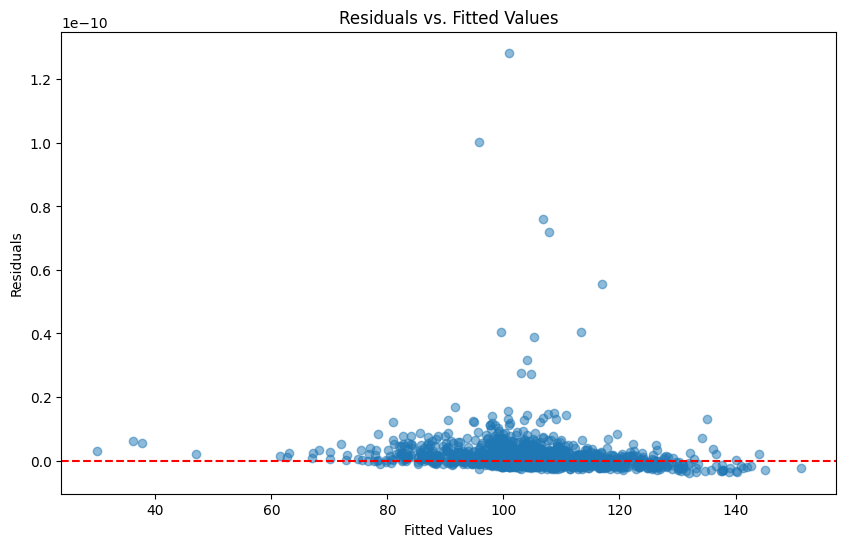

In [17]:
# Calculate Residuals and Fitted Values

# Fitted values
fitted_values = model.fittedvalues

# Residuals
residuals = model.resid

# Plot Residuals vs. Fitted Values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The residuals mostly cluster around 0 which is a positive sign, but the presence of outliers could be a concern, justifying the use of more robust regression methods that can better handle outliers. Additionally, there may be risk of heterscedasticity shown from increasing variability in the residuals as the fitted values increase.

#### 3. Construct the normal probability plot of the residuals. What does this plot tell us?

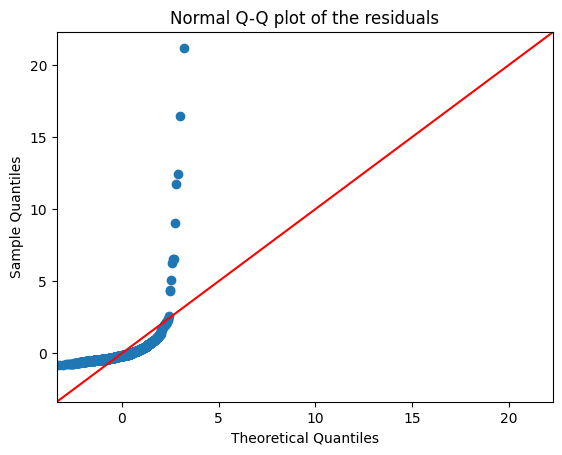

In [18]:
# Generate the normal probability plot
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal Q-Q plot of the residuals')
plt.show()

Several points are deviating substantially from the reference line, suggesting that the residuals aren't following a normal distribution. The deviation from the reference line also suggests outliers.

#### 4. Implement a stepwise variable selection procedure using AIC to find a simpler model. Report on the resulting model.

**Personal Notes for Later Reference:** Stepwise variable selection is a method used in regression analysis to select the best subset of predictors by iteratively considering addition or removal of predictors based on certain criteria like AIC (Akaike Information Criterion). The AIC is a measure of the relative quality of a statistical model for a given set of data. It balances the complexity of the model against how well the model fits the data. Lower AIC values indicate a potentially better model.

To perform stepwise regression in Python, you can use the statsmodels library, which doesn't have direct built-in support for stepwise regression, but you can implement it manually using a combination of forward selection and backward elimination.

In [29]:
def forward_selection(data, response):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        data : pandas DataFrame with all possible predictors and response
        response: string, name of response column in data
    Returns:
        model: an "optimal" fitted statsmodels linear model
        with an intercept selected by forward selection
        based on lowest AIC
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                       ' + '.join(selected + [candidate]))
            score = sm.OLS.from_formula(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = sm.OLS.from_formula(formula, data).fit()
    return model

In [20]:
model = forward_selection(data, 'trade_price')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            trade_price   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     3538.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        22:50:22   Log-Likelihood:                -3166.4
No. Observations:                1620   AIC:                             6375.
Df Residuals:                    1599   BIC:                             6488.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The OLS regression model demonstrates a strong fit with an R-squared value of 0.978, indicating that it explains a high proportion of the variance in the trade price. However, diagnostic tests reveal potential issues: the residuals are not normally distributed and there's a high condition number, suggesting significant multicollinearity among predictors. These findings imply that while the model is statistically significant and predictive, its reliability may be compromised by these underlying issues, necessitating further investigation and possible model adjustments.

#### 5. Repeat the above, but use PRESS instead of AIC. How does the resulting model change?

In [21]:
def calculate_press(y_true, y_pred, X):
    """ Calculate the PRESS statistic for model evaluation. """
    residuals = y_true - y_pred
    h = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T).diagonal()  # Leverage
    press = np.sum((residuals / (1 - h))**2)
    return press

def stepwise_selection_using_press(data, response):
    """ Perform stepwise regression using PRESS for model selection. """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_press = np.inf
    improvement = True

    while remaining and improvement:
        press_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = sm.OLS.from_formula(formula, data).fit()
            y_pred = model.predict(data)
            press = calculate_press(data[response], y_pred, model.model.exog)
            press_with_candidates.append((press, candidate))

        press_with_candidates.sort()
        best_new_press, best_candidate = press_with_candidates[0]
        if current_press > best_new_press:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_press = best_new_press
            improvement = True
        else:
            improvement = False

    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = sm.OLS.from_formula(formula, data).fit()
    return model

# Execute Model
final_model = stepwise_selection_using_press(data, 'trade_price')
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:            trade_price   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     4146.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        22:52:03   Log-Likelihood:                -3170.9
No. Observations:                1620   AIC:                             6378.
Df Residuals:                    1602   BIC:                             6475.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

When comparing models selected using PRESS versus AIC, the PRESS-optimized model uses fewer predictors (17 instead of 20), suggesting a more parsimonious approach without sacrificing explanatory power, as both models exhibit nearly identical R-squared values of 0.978. This indicates that PRESS, by focusing on predictive accuracy, effectively streamlines the model while maintaining robustness, which can be beneficial for avoiding overfitting and enhancing model generalizability.

## Question Two
Refit the model of Question Two with all of the predictors, but first
transform each predictor on the ratio scale using the Yeo-Johnson transformation. (The
objective here is to give each predictor distribution more of a "normal" shape.)
Then, refit the model, but use the Box-Cox procedure to find the optimal transformation of the
response.
Show the results of the resulting model fit, including the plot of residuals versus fitted values.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     18.89
Date:                Sun, 12 May 2024   Prob (F-statistic):          1.73e-174
Time:                        23:33:16   Log-Likelihood:                 15729.
No. Observations:                1620   AIC:                        -3.130e+04
Df Residuals:                    1539   BIC:                        -3.086e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

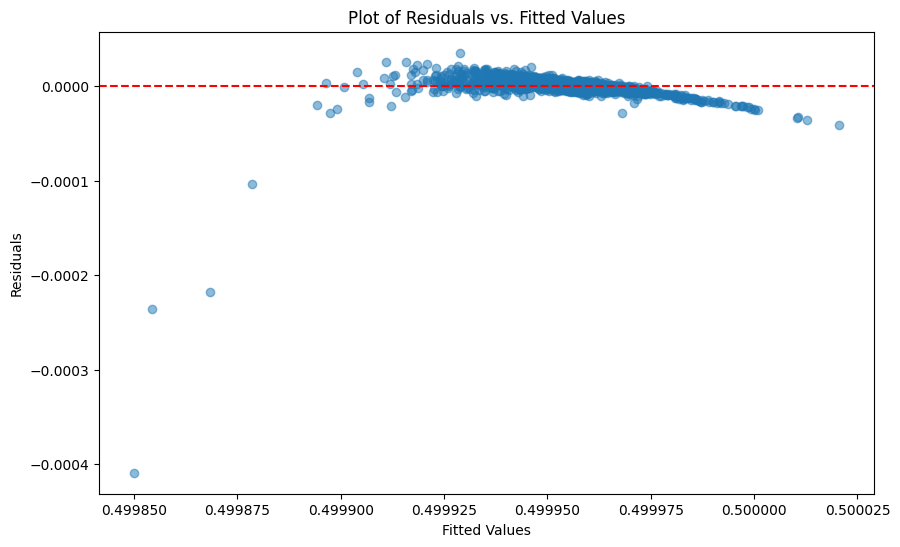

In [28]:
# Finding the optimal lambda for the Box-Cox transformation of the response
def neg_log_likelihood(lambda_):
    # Apply Box-Cox transformation with given lambda
    transformed_response = boxcox(response + 1e-4, lmbda=lambda_)
    model = sm.OLS(transformed_response, sm.add_constant(transformed_predictors))
    results = model.fit()
    return -results.llf

# Using minimize_scalar to find the optimal lambda
optimal_lambda = minimize_scalar(neg_log_likelihood, bounds=(-2, 2), method='bounded').x

# Applying Box-Cox transformation with the optimal lambda found
transformed_response = boxcox(response + 1e-4, lmbda=optimal_lambda)

# Now refitting the OLS model with transformed predictors and response
X = sm.add_constant(transformed_predictors)  # Add a constant for the intercept
model = sm.OLS(transformed_response, X).fit()

# Print the model summary
print(model.summary())

# Plot residuals vs. fitted values
fitted_values = model.fittedvalues
residuals = model.resid
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Plot of Residuals vs. Fitted Values')
plt.show()